In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

In [2]:
# 加载训练数据
mnist_train = torchvision.datasets.FashionMNIST(
    root='~/Datasets/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

100.0%


Extracting C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw



100.0%


Extracting C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw



100.0%


Extracting C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw



100.0%

Extracting C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\kbgs449/Datasets/FashionMNIST\FashionMNIST\raw



In [3]:
# 加载测试数据
mnist_test = torchvision.datasets.FashionMNIST(
    root='~/Datasets/FashionMNIST',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [4]:
def get_fashion_mnist_labels(labels):
    '''返回Fashion-MNIST数据集的文本标签'''
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [5]:
def show_fashion_mnist(images, labels):
    '''展示图像和标签'''
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

In [6]:
print(mnist_train.data.shape)
'''
60000个样本
每个样本大小28*28=784
'''
print(len(mnist_train.targets.unique()))
'''
10个标签
'''

torch.Size([60000, 28, 28])
10


'\n10个标签\n'

In [14]:
class SoftMaxRegression:
    def __init__(self):
        # 初始化模型参数
        self.num_inputs = 784
        self.num_outputs = 10

        self.W = torch.normal(0, 0.01, size=(self.num_inputs, self.num_outputs), requires_grad=True) #每一个像素点的回归系数
        self.b = torch.zeros(self.num_outputs, requires_grad=True) #偏置项

    def soft_max(self, X):
        """   计算softmax
        输入: X, 其中size=(n, 10)

        对每一行X计算softmax

        输出: softmax(X), 其中size=(n, 10)

        注意不要用for实现!!!
        """
        # 为了数值稳定，先减去每一行的最大值
        X_shift = X - X.max(dim=1, keepdim=True).values
        exp_x = torch.exp(X_shift)
        # 对每一行做归一化
        return exp_x / exp_x.sum(dim=1, keepdim=True)


    def net(self, X):
        """定义模型"""
        X = X.view(-1, self.num_inputs)
        return self.soft_max(torch.mm(X, self.W) + self.b)

    def one_hot_encoder(self, y):
        """独热编码"""
        a = torch.zeros((len(y), self.num_outputs))
        for idx, i in enumerate(y):
            a[idx, int(i)] = 1
        return a
    
    def cross_entropy(self, y_hat, y):
        y_pred_enc = self.one_hot_encoder(y)
        """   损失函数
        输入: 
            y_hat, 模型预测概率分布, 其中size=(n, 10)
            y, 真实标签, 其中size=(n, 1)
        
        先对y进行独热编码转为y_pred_enc使其size=(n, 10), 然后计算y_pred_enc与y_hat的交叉熵损失

        输出: y_pred_enc与y_hat的 n 个交叉熵损失值

        注意不要用for实现!!!
        """
        eps = 1e-9   # 防止 log(0)
        # 交叉熵: -∑ y * log(y_hat)，按样本在 dim=1 上求和，得到形状 (n,)
        loss_per_sample = -(y_pred_enc * torch.log(y_hat + eps)).sum(dim=1)
        return loss_per_sample


    def accuracy(self, y_hat, y):
        """   统计预测正确的数量
        输入: 
            y_hat, 模型预测概率分布, 其中size=(n, 10)
            y, 真实标签, 其中size=(n, 1)
        
        根据概率分布y_hat的标签, 然后和真实标签对比统计预测正确的数量

        输出: correct_count 预测正确的数量

        注意不要用for实现!!!
        """
        # 取每一行概率最大的类别索引作为预测标签
        pred_labels = y_hat.argmax(dim=1)
        # y 可能是 (n,) 或 (n,1)，统一展平成一维
        real_labels = y.view(-1)
        correct_count = (pred_labels == real_labels).sum().item()
        return correct_count


    def evaluate_accuracy(self, net, data_iter):
        """计算在指定数据集上模型的精度"""
        correct_count, total_count = 0, 0
        with torch.no_grad():
            for X, y in data_iter:
                correct_count += self.accuracy(net(X), y)
                total_count += y.numel()
        return correct_count / total_count

    def train_epoch(self, net, train_iter, loss):
        """训练模型的一个迭代周期"""
        total_loss, correct_count, total_count = 0, 0, 0
        lr = 0.1
        for X, y in train_iter:
            y_hat = net(X)
            # 计算损失函数
            l = loss(y_hat, y)
            # 求梯度
            l.mean().backward()
            # 更新训练参数
            self.W.data -= lr * self.W.grad
            self.b.data -= lr * self.b.grad
            # 梯度清零
            self.W.grad.data.zero_()
            self.b.grad.data.zero_()
            #计算指标
            total_loss += l.sum().item()
            correct_count += self.accuracy(y_hat, y)
            total_count += y.numel()
        # 返回训练损失和训练精度
        return total_loss / total_count, correct_count / total_count

    def train(self, net, train_iter, test_iter, loss, num_epochs):
        """训练模型"""
        for epoch in range(num_epochs):
            train_metrics = self.train_epoch(net, train_iter, loss)
            test_acc = self.evaluate_accuracy(net, test_iter)
            train_loss, train_acc = train_metrics
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}, train_acc: {train_acc}, test_acc: {test_acc}')
            assert train_acc <= 1 and train_acc > 0.7, train_acc
            assert test_acc <= 1 and test_acc > 0.7, test_acc

    def predict(self, net, test_iter, n=10):
        """预测标签"""
        X, y = next(iter(test_iter))
        trues = get_fashion_mnist_labels(y)
        preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
        titles = [f'T:{t}\nP:{p}' for t, p in zip(trues, preds)] 
        show_fashion_mnist(X[0:n], titles[0:n]) 

    def run(self,train_iter,test_iter,num_epochs = 1):
        self.train(self.net, train_iter, test_iter, self.cross_entropy, num_epochs)
        self.predict(self.net, test_iter)


Epoch [1/1], Loss: 0.7839116760253906, train_acc: 0.7478666666666667, test_acc: 0.7795


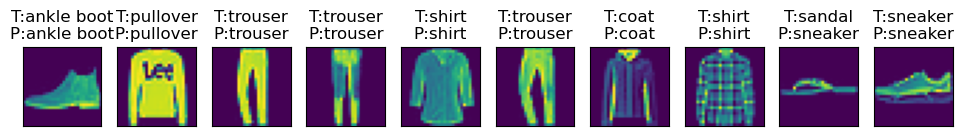

In [15]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)
SMR = SoftMaxRegression()
SMR.run(train_iter,test_iter)

In [9]:
# 定义骨干网络
import torch
import torch.nn as nn
import torch.optim as optim


class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)   # 输出 10 个类别的 logits（不要加 softmax）
        )

    def forward(self, x):
        # x: (batch, 1, 28, 28)
        x = self.flatten(x)
        x = self.net(x)
        return x


In [10]:
# Dataloader
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size, shuffle=False, num_workers=4
)

model = MyNet()

criterion = nn.CrossEntropyLoss()              # 分类用的交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 也可以用 SGD

In [11]:
# 精度计算函数
def MyAccuracy(pred_logits, real_labels):
    """
    pred_logits: 模型输出的 (batch, 10) 的 logits
    real_labels: 真实标签 (batch,)
    返回: 该 batch 的分类精度 (0~1)
    """
    pred = pred_logits.argmax(dim=1)
    correct = (pred == real_labels).sum().item()
    total = real_labels.size(0)
    return correct / total


In [ ]:
# 训练循环
num_epochs = 10  # 可以根据需要改成 20 或 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_samples = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)                 # 前向传播
        loss = criterion(output, y_batch)       # 计算损失
        loss.backward()                         # 反向传播
        optimizer.step()                        # 更新参数

        batch_size_now = y_batch.size(0)
        running_loss += loss.item() * batch_size_now
        total_samples += batch_size_now

    # 计算一个 epoch 的平均 loss、训练精度和测试精度
    avg_loss = running_loss / total_samples

    # 训练精度
    model.eval()
    with torch.no_grad():
        train_correct, train_total = 0, 0
        for x_batch, y_batch in train_loader:
            logits = model(x_batch)
            train_correct += (logits.argmax(dim=1) == y_batch).sum().item()
            train_total += y_batch.size(0)
        train_acc = train_correct / train_total

        # 测试精度
        test_correct, test_total = 0, 0
        for x_batch, y_batch in test_loader:
            logits = model(x_batch)
            test_correct += (logits.argmax(dim=1) == y_batch).sum().item()
            test_total += y_batch.size(0)
        test_acc = test_correct / test_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch [1/10] Loss: 0.6406, Train Acc: 0.8469, Test Acc: 0.8325
Epoch [2/10] Loss: 0.4187, Train Acc: 0.8470, Test Acc: 0.8350
Epoch [3/10] Loss: 0.3750, Train Acc: 0.8733, Test Acc: 0.8578
Epoch [4/10] Loss: 0.3426, Train Acc: 0.8847, Test Acc: 0.8654
Epoch [5/10] Loss: 0.3228, Train Acc: 0.8901, Test Acc: 0.8711
Epoch [6/10] Loss: 0.3055, Train Acc: 0.8782, Test Acc: 0.8576
Epoch [7/10] Loss: 0.2906, Train Acc: 0.8973, Test Acc: 0.8735
Epoch [8/10] Loss: 0.2776, Train Acc: 0.9044, Test Acc: 0.8818
Epoch [9/10] Loss: 0.2698, Train Acc: 0.9061, Test Acc: 0.8819
Epoch [10/10] Loss: 0.2592, Train Acc: 0.9094, Test Acc: 0.8802


In [ ]:
# 预测
model.eval()
with torch.no_grad():
    test_x_batch, test_y_batch = next(iter(test_loader))  # 取一个 batch
    logits = model(test_x_batch)
    batch_score = MyAccuracy(logits, test_y_batch)
    print("One mini-batch accuracy:", batch_score)


One mini-batch accuracy: 0.85546875


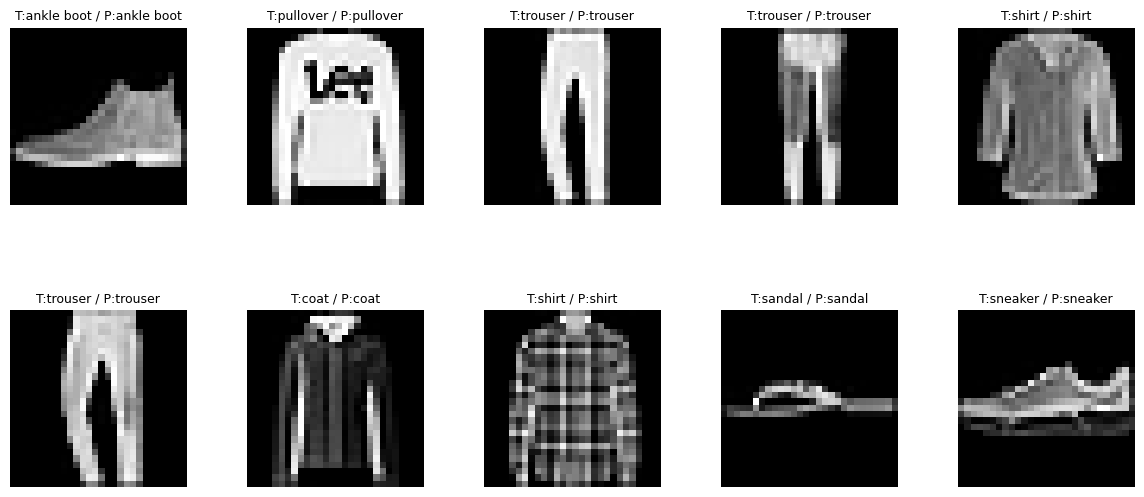

In [ ]:
model.eval()
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    logits = model(test_images)
    preds = logits.argmax(dim=1)
    titles = [f'T:{t} / P:{p}' for t, p in zip(get_fashion_mnist_labels(test_labels), get_fashion_mnist_labels(preds))]
    show_fashion_mnist(test_images[:10], titles[:10])
